# 4.1: 矩阵乘积态（MPS）的定义及模方的计算

矩阵乘积态(Matrix Product State, 简称MPS)：一种最简单、常用的张量网络

有限长开放边界矩阵乘积态(finite-size open-boundary MPS)

$$
\varphi_{s_0s_1...s_{N-1}} = \sum_{\alpha_1...\alpha_{N-1}} A^{(0)}_{s_0\alpha_1}A^{(1)}_{\alpha_1s_1\alpha_2}...A^{(N-2)}_{\alpha_{N-2}s_{N-2}\alpha_{N-1}}A^{(N-1)}_{\alpha_{N-1}s_{N-1}}
$$

{$A^{(n)}$}被称为MPS的局域张量(local tensors)

局域张量的个数被称为MPS的长度，"有限长"(finite-length或finite-size)指MPS由有限多个局域张量的收缩构成

等号左侧$\varphi$为局域张量收缩所得的高阶张量，被称为全局张量(Global Tensor)

全局张量的指标{$s_n$}被称为开放指标(Open Indexes)或物理指标(Physical Indexes)，该类指标在右侧只出现在某个局域张量，且不被求和

物理指标的个数与维数(物理维数)决定全局张量的阶数与维数

![mps_example](./images/mps_example.png)
> 长度为 5 的开放边界的 MPS

{$a_m$}被称为虚拟指标 (virtual indexes) 或几何指标 (geometrical index)，在右侧被两个相邻局域张量共有，且会被求和掉，因此不出现在全局张量中；

虚拟指标的维数被称为虚拟维数，其为MPS的超参数，决定了MPS的参数复杂度，但与全局张量的维数无关

> 虚拟指标的维数会影响张量的秩，从而影响能表达的纠缠熵

设物理维数为 $d$，虚拟维数为 $\chi$，MPS的复杂度满足 $2d\chi + (N-2)d\chi^2 \sim O(Nd\chi^2)$

即参数复杂度与$N$（全局张量阶数或MPS长度）线性相关；

相对的，全局张量的参数复杂度满足 $O(d^N)$ 其与 $N$ 指数相关。

若视 $\chi$ 为常数，则矩阵乘积态在形式上将$N$阶张量的参数复杂度从指数级降低为线性级。

## Calculate Global Tensor

In [1]:
# |default_exp mps.functional
# |export
import torch
from tensor_network.tensor_utils import tensor_contract
from typing import List
from enum import Enum

In [2]:
# |export
class MPSType(Enum):
    """
    The type of the MPS
    """

    Open = "Open"
    Periodic = "Periodic"

    @staticmethod
    def get_mps_type(mps_tensors: List[torch.Tensor]) -> "MPSType":
        """
        Determine the type of the MPS
        """
        if mps_tensors[0].shape[0] == 1 and mps_tensors[-1].shape[2] == 1:
            return MPSType.Open
        else:
            return MPSType.Periodic


def gen_random_mps_tensors(
    length: int,
    physical_dim: int,
    virtual_dim: int,
    mps_type: MPSType,
    dtype: torch.dtype | None = None,
    device: torch.device | None = None,
) -> List[torch.Tensor]:
    """
    Generate random MPS tensors

    Args:
        length: int, the length of the MPS
        physical_dim: int, the physical dimension of the MPS
        virtual_dim: int, the virtual dimension of the MPS
        mps_type: MPSType, the type of the MPS
        dtype: torch.dtype, the dtype of the MPS
        device: torch.device, the device of the MPS

    Returns:
        List[torch.Tensor], the MPS tensors
    """
    if mps_type == MPSType.Open:
        mps_tensors = []
        mps_tensors.append(torch.randn(1, physical_dim, virtual_dim, dtype=dtype, device=device))
        rand_tensor = torch.randn(
            length - 2, virtual_dim, physical_dim, virtual_dim, dtype=dtype, device=device
        )
        for i in range(length - 2):
            mps_tensors.append(rand_tensor[i])
        mps_tensors.append(torch.randn(virtual_dim, physical_dim, 1, dtype=dtype, device=device))
        return mps_tensors
    elif mps_type == MPSType.Periodic:
        mps_tensor = torch.randn(
            length, virtual_dim, physical_dim, virtual_dim, dtype=dtype, device=device
        )
        return [mps_tensor[i] for i in range(length)]
    else:
        raise NotImplementedError(f"MPS type {mps_type} is not implemented")


def calc_global_tensor_by_contract(mps_tensors: List[torch.Tensor]) -> torch.Tensor:
    """
    Calculate the global tensor by contracting the MPS tensors

    Args:
        mps_tensors: List[torch.Tensor], the MPS tensors

    Returns:
        torch.Tensor, the global tensor
    """

    length = len(mps_tensors)
    dim_names = []
    for i in range(length):
        dim_name_list = [f"t{i}{j}" for j in range(3)]
        dim_names.append(dim_name_list)

    input_expression = ",".join([" ".join(dim_names[i]) for i in range(length)])
    output_dims = [dim_name_list[1] for dim_name_list in dim_names]
    output_dims = [dim_names[0][0]] + output_dims + [dim_names[-1][-1]]
    output_expression = " ".join(output_dims)

    contract_dims = []
    for i in range(length - 1):
        right_dim = dim_names[i][2]
        left_dim = dim_names[i + 1][0]
        contract_dims.append({right_dim, left_dim})

    mps_type = MPSType.get_mps_type(mps_tensors)

    if mps_type == MPSType.Periodic:
        front_left_dim = dim_names[0][0]
        end_right_dim = dim_names[-1][2]
        contract_dims.append({front_left_dim, end_right_dim})

    return tensor_contract(
        *mps_tensors, ein_expr=f"{input_expression} -> {output_expression}", dims=contract_dims
    ).squeeze()


def calc_global_tensor_by_tensordot(mps_tensors: List[torch.Tensor]) -> torch.Tensor:
    """
    Calculate the global tensor by tensordot

    Args:
        mps_tensors: List[torch.Tensor], the MPS tensors

    Returns:
        torch.Tensor, the global tensor
    """
    length = len(mps_tensors)
    psi = mps_tensors[0]
    for i in range(1, length):
        psi = torch.tensordot(psi, mps_tensors[i], dims=([-1], [0]))

    mps_type = MPSType.get_mps_type(mps_tensors)

    if mps_type == MPSType.Periodic:
        return torch.einsum("a...a->...", psi)
    elif mps_type == MPSType.Open:
        return psi.squeeze()
    else:
        raise NotImplementedError(f"MPS type {mps_type} is not implemented")

### Benchmark

In [3]:
from time import time
from matplotlib import pyplot as plt

In [4]:
def visualize_2d_tensor(
    tensor: torch.Tensor,
    x_label: str,
    y_label: str,
    title: str,
    x_ticks: List[int],
    x_ticks_labels: List[str],
    y_ticks: List[int],
    y_ticks_labels: List[str],
):
    plt.figure(figsize=(12, 8))

    # Create a heatmap of the tensor with red-blue colormap
    # Red for positive values, blue for negative
    im = plt.imshow(tensor, cmap="RdBu_r", aspect="auto")
    plt.colorbar(im, label="Time Difference (ms)")

    # Set labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Set x and y ticks to show actual values
    plt.xticks(x_ticks, x_ticks_labels)
    plt.yticks(y_ticks, y_ticks_labels)

    # Add grid for better readability
    plt.grid(False)

    # Add annotations (optional)
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            plt.text(j, i, f"{tensor[i, j]:.3f}", ha="center", va="center")

    plt.tight_layout()
    plt.show()

    print(f"Min: {tensor.min()}\nMax: {tensor.max()}")

In [5]:
d = 2  # qubit dimension
dtype = torch.float32

chi = 3
length = 4

mps_tensors = gen_random_mps_tensors(length, d, chi, MPSType.Open, dtype)

global_tensor = calc_global_tensor_by_contract(mps_tensors)
global_tensor_ref = calc_global_tensor_by_tensordot(mps_tensors)
assert torch.allclose(global_tensor, global_tensor_ref)

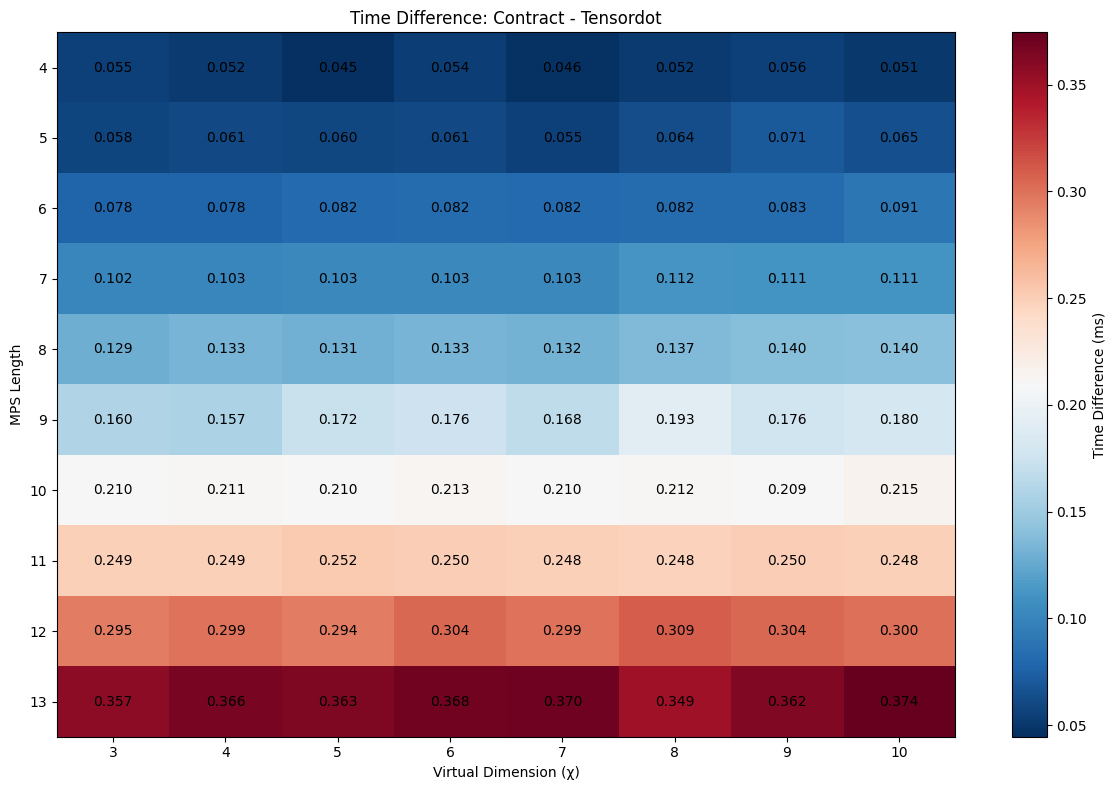

Min: 0.04461764916777611
Max: 0.37447449564933777


In [6]:
d = 2  # qubit dimension
num_trials = 50
dtype = torch.float32

min_chi = 3
max_chi = 10

min_length = 4
max_length = 13

results = torch.empty((max_length - min_length + 1, max_chi - min_chi + 1, 2), dtype=torch.float32)

for length in range(min_length, max_length + 1):
    for chi in range(min_chi, max_chi + 1):
        length_idx = length - min_length
        chi_idx = chi - min_chi
        mps_tensors = gen_random_mps_tensors(length, d, chi, MPSType.Open, dtype)

        start_time = time()
        for _ in range(num_trials):
            global_tensor = calc_global_tensor_by_contract(mps_tensors)
        end_time = time()
        results[length_idx, chi_idx, 0] = (end_time - start_time) / num_trials

        start_time = time()
        for _ in range(num_trials):
            global_tensor = calc_global_tensor_by_tensordot(mps_tensors)
        end_time = time()
        results[length_idx, chi_idx, 1] = (end_time - start_time) / num_trials


diff_ms = (results[:, :, 0] - results[:, :, 1]) * 1000  # contract_time - tensordot_time
visualize_2d_tensor(
    diff_ms,
    "Virtual Dimension (χ)",
    "MPS Length",
    "Time Difference: Contract - Tensordot",
    range(max_chi - min_chi + 1),
    range(min_chi, max_chi + 1),
    range(max_length - min_length + 1),
    range(min_length, max_length + 1),
)

## Calculate Norm

计算 MPS 的模方不需要计算 Global Tensor 而是可以直接将局域张量取共轭然后计算，如下图

![mps_norm](./images/mps_norm.png)

引入标量 $v=1$，并将其变形为 $(1\times1)$ 的二阶张量 $v$，并按照如下公式进行"更新"

$$\sum_{s_na_na'_n} v_{a_na'_n}A^{(n)*}_{a_ns_na_{n+1}}A^{(n)}_{a'_ns_na'_{n+1}} = v_{a_{n+1}a'_{n+1}}$$

![mps_norm_reduce](./images/mps_norm_reduce.png)

为防止发散，每次对 $v$ 进行归一化操作：$v \leftarrow v/|v|$

上述计算的复杂度仅关于 $N$ 线性增长，约为

$$O(Nd\chi^3)$$

记第 $n$ 次的归一化因子为 $c_n = |v|$，则矩阵乘积态的模方满足

$$|\varphi|^2 = \prod_{n=0}^{N-1} c_n$$

若需通过对局域张量的处理将矩阵乘积态归一化，可更新 $A^{(n)}$ 为

$$A^{(n)}/\sqrt{c_n} \rightarrow A^{(n)}$$

In [7]:
# |export
def calculate_mps_norm_factors(
    mps_tensors: List[torch.Tensor], __efficient_mode: bool = True
) -> torch.Tensor:
    """
    Calculate the norm factors of the MPS

    Args:
        mps_tensors: List[torch.Tensor], the MPS tensors
        __efficient_mode: bool, whether to use efficient mode

    Returns:
        torch.Tensor, the norm factors
    """

    assert len(mps_tensors) >= 1, "MPS must have at least one tensor"
    conjugates = [t.conj() for t in mps_tensors]
    length = len(conjugates)
    device = conjugates[0].device
    dtype = conjugates[0].dtype
    v = torch.ones(1, 1, dtype=dtype, device=device)  # dims: a b
    norm_factors = torch.empty(length, dtype=dtype, device=device)
    if __efficient_mode:
        for i in range(length):
            v = torch.einsum("ab,aix->bix", v, conjugates[i])
            v = torch.einsum("bix,biy->xy", v, mps_tensors[i])
            norm_factor = v.norm()
            v /= norm_factor
            norm_factors[i] = norm_factor
    else:
        for i in range(length):
            v = torch.einsum("ab,aix,biy->xy", v, conjugates[i], mps_tensors[i])
            norm_factor = v.norm()
            v /= norm_factor
            norm_factors[i] = norm_factor

    return norm_factors

In [8]:
physical_dim = 2  # qubit dimension
dtype = torch.float32

min_virtual_dim = 3
max_virtual_dim = 10

min_length = 4
max_length = 12

for length in range(min_length, max_length + 1):
    for virtual_dim in range(min_virtual_dim, max_virtual_dim + 1):
        mps_tensors = gen_random_mps_tensors(length, physical_dim, virtual_dim, MPSType.Open, dtype)
        normalization_factors = calculate_mps_norm_factors(mps_tensors)
        norm = torch.prod(normalization_factors).sqrt()
        global_tensor = calc_global_tensor_by_tensordot(mps_tensors)
        assert torch.allclose(norm, global_tensor.norm())

### Benchmark

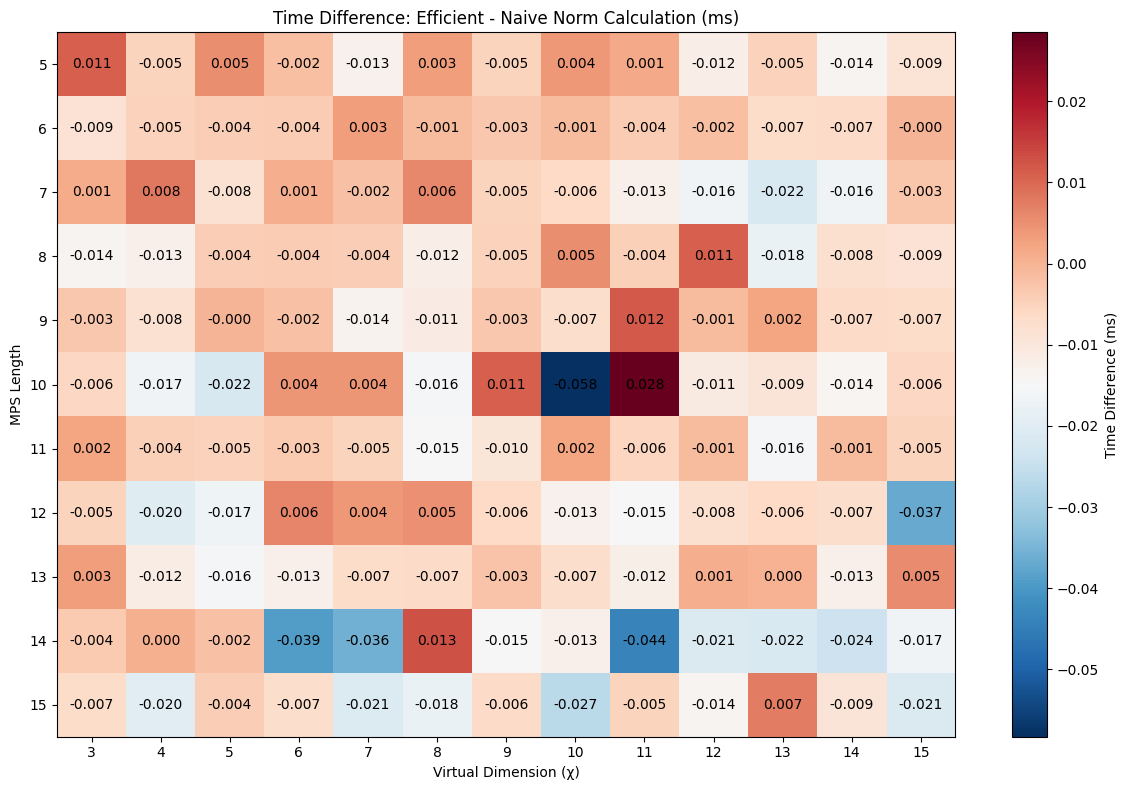

Min: -0.05828380584716797
Max: 0.028481483459472656


In [9]:
physical_dim = 2  # qubit dimension
dtype = torch.float32

min_virtual_dim = 3
max_virtual_dim = 15

min_length = 5
max_length = 15

num_trials = 50


diff_results = torch.empty(
    (max_length - min_length + 1, max_virtual_dim - min_virtual_dim + 1), dtype=torch.float32
)

for length in range(min_length, max_length + 1):
    for virtual_dim in range(min_virtual_dim, max_virtual_dim + 1):
        mps_tensors = gen_random_mps_tensors(length, physical_dim, virtual_dim, MPSType.Open, dtype)
        start_time = time()
        for _ in range(num_trials):
            norm_factors_efficient_mode = calculate_mps_norm_factors(
                mps_tensors, __efficient_mode=True
            )
        end_time = time()
        time_cost_efficient_mode = (end_time - start_time) / num_trials

        start_time = time()
        for _ in range(num_trials):
            norm_factors_naive_mode = calculate_mps_norm_factors(
                mps_tensors, __efficient_mode=False
            )
        end_time = time()
        time_cost_naive_mode = (end_time - start_time) / num_trials
        diff = (time_cost_efficient_mode - time_cost_naive_mode) * 1000
        diff_results[length - min_length, virtual_dim - min_virtual_dim] = diff
        assert torch.allclose(norm_factors_efficient_mode, norm_factors_naive_mode)


visualize_2d_tensor(
    diff_results,
    "Virtual Dimension (χ)",
    "MPS Length",
    "Time Difference: Efficient - Naive Norm Calculation (ms)",
    range(max_virtual_dim - min_virtual_dim + 1),
    range(min_virtual_dim, max_virtual_dim + 1),
    range(max_length - min_length + 1),
    range(min_length, max_length + 1),
)

## Normalize MPS

In [10]:
# |export
def normalize_mps(mps_tensors: List[torch.Tensor]) -> List[torch.Tensor]:
    """
    Normalize the MPS

    Args:
        mps_tensors: List[torch.Tensor], the MPS tensors

    Returns:
        List[torch.Tensor], the normalized MPS tensors
    """
    norms = calculate_mps_norm_factors(mps_tensors)
    normalization_factors = 1 / norms.sqrt()
    middle_tensors = torch.stack(
        mps_tensors[1:-1]
    )  # (length - 2, virtual_dim, physical_dim, virtual_dim)
    middle_factors = normalization_factors[1:-1].reshape(-1, 1, 1, 1)
    normalized_middle_tensors = middle_tensors * middle_factors
    front_tensor = mps_tensors[0] * normalization_factors[0]
    end_tensor = mps_tensors[-1] * normalization_factors[-1]
    return [front_tensor] + [normalized_middle_tensors[i] for i in range(length - 2)] + [end_tensor]

In [11]:
mps_tensors = gen_random_mps_tensors(length, physical_dim, virtual_dim, MPSType.Open, dtype)
normalized_mps_tensors = normalize_mps(mps_tensors)
norms = calculate_mps_norm_factors(normalized_mps_tensors)
norm_ref = calc_global_tensor_by_tensordot(normalized_mps_tensors).norm()
assert torch.allclose(norm_ref, torch.prod(norms).sqrt())
assert torch.allclose(norm_ref, torch.ones_like(norm_ref))

In [ ]:
# TODO: check all the functions for periodic MPS